# Create training data interactively

This notebook helps you interactively create labeled bird audio clips using only one example clip. All example data need to be pre0cinoyted using `embed.ipynb`

## Configuration and Imports.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from etils import epath
import numpy as np
from chirp import audio_utils
from chirp.inference.search import bootstrap
from chirp.inference.search import search
from chirp.inference.search import display

In [2]:
# Specify species your working on
target_class = "Train"

# Working dir for saving products
working_dir = "/workspaces/2023_ECCC4_Biodiv/data/"
embeddings_path = working_dir + "embeddings"

# Label path
# It will identify all the folders with species audio data in
# The folder names need to match the species name, as it 
# is used as the class label.
# If only one species folder present, then only one class will be used
labeled_data_path = epath.Path(working_dir) / "labels_noise"

# Example audio path
example_audio_path = working_dir + "example_label"
os.makedirs(example_audio_path, exist_ok=True)

In [3]:
# Load Project State and Models
if (embeddings_path or (epath.Path(working_dir) / 'embeddings/config.json').exists()):
  if not embeddings_path:
    embeddings_path = epath.Path(working_dir) / 'embeddings'
  # Get relevant info from the embedding configuration.
  bootstrap_config = bootstrap.BootstrapConfig.load_from_embedding_path(
      embeddings_path=embeddings_path,
      annotated_path=labeled_data_path)
else:
  raise ValueError('No embedding configuration found.')

project_state = bootstrap.BootstrapState(
    bootstrap_config, baw_auth_token='')

## Prepare label for search

In [4]:
# You may specify:
# * an audio filepath (like `/home/me/audio/example.wav`),
# * a Xeno-Canto id (like `xc12345`), or
# * an audio file URL (like https://upload.wikimedia.org/wikipedia/commons/7/7c/Turdus_merula_2.ogg).

# Open P:\Projets\Actif\2023_ECCC4_Biodiv\3-Analyses\1-Data\BirdRecordingsLabels\Cornell_University_Northern_America
# And vind an example call of your species
# Use this file to find the common name "P:\Projets\Actif\2023_ECCC4_Biodiv\3-Analyses\1-Data\Biodiversity\Species_List_Quebec.csv"
audio_path = example_audio_path + "/" +"20240601_013000___560.0.WAV" # eg."Wood Duck 06 Calls US-NY.mp3" , "Wood Duck 01 Calls US-NY.mp3"
start_s = 0

window_s = bootstrap_config.model_config['window_size_s']
sample_rate = bootstrap_config.model_config['sample_rate']
audio = audio_utils.load_audio(audio_path, sample_rate)

# Selected window.
st = int(start_s * sample_rate)
end = int(st + window_s * sample_rate)
if end > audio.shape[0]:
  end = audio.shape[0]
  st = max([0, int(end - window_s * sample_rate)])
audio_window = audio[st:end]

query_audio = audio_window
sep_outputs = None

outputs = project_state.embedding_model.embed(query_audio)
query = outputs.pooled_embeddings('first', 'first')

I0000 00:00:1740944655.123237    3343 service.cc:145] XLA service 0x55e874aad5f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740944655.123321    3343 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
W0000 00:00:1740944655.310784    3343 assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
I0000 00:00:1740944662.408706    3343 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


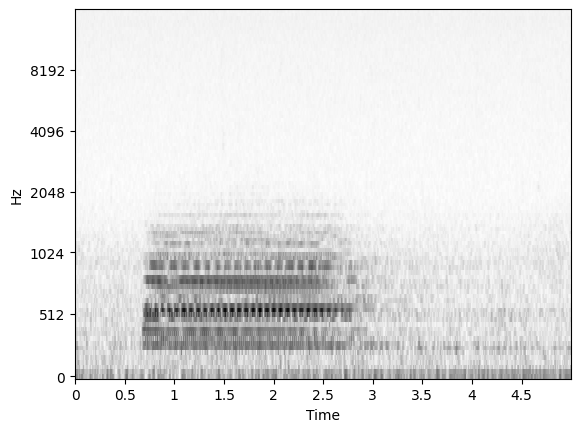

In [5]:
# View example
display.plot_audio_melspec(audio, sample_rate)

## Search embeddings

In [6]:
# Number of search results to capture.
top_k = 100

# Target distance for search results.
# This lets us try to hone in on a 'classifier boundary' instead of
# just looking at the closest matches.
# Set to 'None' for raw 'best results' search.
target_score = None 

# Maximimum Inner-Product (mip) generally gives best results.
metric = 'mip'  #['euclidean', 'mip', 'cosine']

# If True, produce a fully-random sample of data, ignoring similarity.
random_sample = False

ds = project_state.create_embeddings_dataset(shuffle_files=True)
results, all_scores = search.search_embeddings_parallel(
    ds, 
    query,
    hop_size_s=bootstrap_config.embedding_hop_size_s,
    top_k=top_k,
    target_score=target_score,
    score_fn=metric,
    random_sample=random_sample)

263929it [02:57, 1490.52it/s]


## Manually assign labels

In [ ]:
# Samples per page
samples_per_page = 20
page_state = display.PageState(
    np.ceil(len(results.search_results) / samples_per_page))

# Display pages with figures and audio
display.display_paged_results(
    results, page_state, samples_per_page,
    project_state=project_state,
    embedding_sample_rate=project_state.embedding_model.sample_rate,
    exclusive_labels=False,
    checkbox_labels=[target_class, 'unknown'],
    max_workers=8,
)

In [8]:
# Save annotated examples.
results.write_labeled_data(
     bootstrap_config.annotated_path,
     project_state.embedding_model.sample_rate)

Wrote 25 examples for label Train
Wrote 1 examples for label Train exists
